## Expectation Maximization for Gaussian Mixture Model 
#### we will implement gaussian mixture model (GMM) in this section. We will the same datasets from homework 3. Firstlty, let's load those datasets from the /gmm_datasets/ folder

## Part a & b

K-means:

1. Hard assigns a point to a certain cluster
2. It uses euclidean distance to determine the distance between points and cenroids. 

GMM:

1. Soft assigns a point to clusters by the probability of the point belonging to a certain cluster. 
2. It does not depend on the euclidean distance but the expectation. To be more specific, it use the probability of the point belonging to a certain cluster. 

## Part c

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, calinski_harabaz_score
from scipy.stats import norm
from scipy.special import logsumexp
from numpy import einsum
from pandas import DataFrame
from util import *

In [2]:
## you need to change the directory to your local dirs
directory = 'gmm_datasets/'

dataset1 = np.loadtxt(directory + "dataset1.txt",
                    dtype = {'names': ('x1', 'x2', 'label'), 'formats': (float, float, int)},
                    delimiter="\t")
dataset2 = np.loadtxt(directory + "dataset2.txt",
                   dtype = {'names': ('x1', 'x2', 'label'), 'formats': (float, float, int)}, 
                   delimiter="\t")
dataset3 = np.loadtxt(directory + "dataset3.txt",
                   dtype = {'names': ('x1', 'x2', 'label'), 'formats': (float, float, int)}, 
                   delimiter="\t")

=================== data 1 ======================


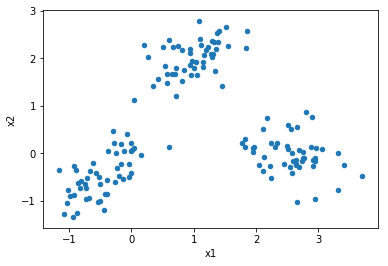

===================== data 2 ===================


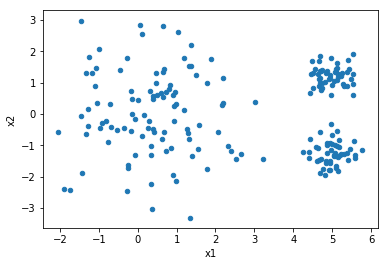

================= data 3 ==================


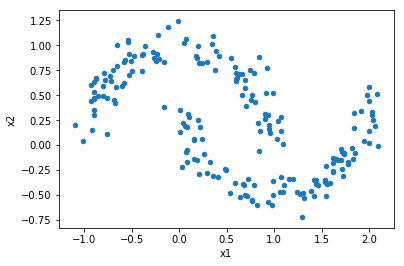

In [3]:
def create_io_matrix(d): 
    """
    formats the input data in a matrix format (n × d) where d is the number of dimentions and n is the number of data points 
    formats the label data in a matrix format (n × 1) where n is the number of data points 
    """
    matrix_input = [[x1, x2] for x1, x2, l in d]
    matrix_labels = [l for x1, x2, l in d]
    
    return (np.array(matrix_input), np.array(matrix_labels))

dataset1_matrix, data1_labels = create_io_matrix(dataset1)
dataset2_matrix, data2_labels = create_io_matrix(dataset2)
dataset3_matrix, data3_labels = create_io_matrix(dataset3)
############# initial data visualization 

df_1 = DataFrame(dataset1_matrix, columns = ['x1', 'x2'])
df_1.plot(kind='scatter', x = 'x1', y = 'x2')

print("=================== data 1 ======================")
plt.show()

df_2 = DataFrame(dataset2_matrix, columns = ['x1', 'x2'])
df_2.plot(kind='scatter', x = 'x1', y = 'x2')

print("===================== data 2 ===================")
plt.show()

df_3 = DataFrame(dataset3_matrix, columns = ['x1', 'x2'])
df_3.plot(kind='scatter', x = 'x1', y = 'x2')

print("================= data 3 ==================")
plt.show()

data1 = np.asarray(dataset1_matrix)
data2 = np.asarray(dataset2_matrix)
data3 = np.asarray(dataset3_matrix)
labels1 = np.asarray(data1_labels)
labels2 = np.asarray(data2_labels)
labels3 = np.asarray(data3_labels)

### Now we will start to implement GMM. 

### 1) implement the initialization function. It's already done for you.

In [4]:
def initialization(data, K): 
    """
    gets the initial values of the means and variances 
    means : K × D, where each row is the mean for cluster k
    covs : K × D, where the each row the diagonal elements of covariance for cluster k
    """
    N, D = np.shape(data)
    
    mu_0 = np.mean(data,0)
    cov = np.cov(data.T)
    init_mus = mvn.rvs(size=K, mean=mu_0, cov=cov)
    init_covs = np.tile(cov,(K,1,1))
    return init_mus, init_covs

### 2) E-step

Now we compute the cluster assignments. Remember that we are doing soft clustering, so every point $y_{n}$ is associated with every cluster to some degree. Same as the lecture slides, we use the notation $\gamma_{n,k}$:

$$ \gamma_{n,k}:= p(z_{n} = k | y_{n}, \theta) \propto p(y_{n} | z_n = k, \mu_{k}, \Sigma_{k}) Pr(z_n = k ; \pi)$$ 

where we assume the prior is $Pr(z_n = k ; \pi) = \frac{1}{K}$, and $\theta$ is the parameters of the clusters (means and covariances). Since $\gamma_{n,k}$ is probability, we need to normalize the density as:


$$ \gamma_{n,k} = \frac{p(y_{n} | z_n = k, \mu_{k}, \Sigma_{k}) * 1 / K} {\sum_{k'} p(y_{n} \ z_n = k \mu_{k'}, \Sigma_{k'})) * 1 / K} = \frac{p(y_{n} | z_n = k, \mu_{k}, \Sigma_{k})} {\sum_{k'} p(y_{n} \ z_n = k \mu_{k'}, \Sigma_{k'}))} $$

Note: To avoid underflowing, we work with $\log \gamma$ instead (so that we don't end up with a bunch $\gamma$ matrix full of NaNs!). Just careful when you're summing or multiplying in log form. You can use `logsumexp` from scipy, imported below. Make sure you read its documentation first, as this method is a friend to all probabilistic ML people. 

In [5]:
def E_step(data, mus, covs, K): 
    """
    the cluster assignments is a N × K 
    matrix that specifies probability that each point belongs to cluster k
    """
    N, D = data.shape
    log_gammas = np.zeros((N, K))
    """
    *** fill in the blank ***
    compute the log of gammas given the previous means and covariances
    """
    for k in range(K):
        log_gamma_k = mvn.logpdf(data, mus[k], covs[k])
        log_gammas[:, k] = log_gamma_k
    log_gammas = log_gammas - logsumexp(log_gammas, axis=1)[:, None]
    return log_gammas


### Comments on avoiding underflow and overflow
When we calculating $\gamma$, the number is going to be underflow because the probability is really small and may be even lower than the minimum number a machine can recognize. As a result, we take log$\gamma$ to avoid this. The reason is, when taking log of a number, we get the exponential which is much less likely to underflow or overflow. 

### 3) M-step

Now we compute the new parameters of these clusters based on the computed $\gamma$ in the E-step. You first must compute the number of points (or the total amount of association) to each cluster:

$$ N_{k} = \sum_{n=1}^{N} \gamma_{n,k}  $$ 

And then based on this, we compute the new mean and the covariance for each cluster, shown below:

\begin{align} 
\mu_{k}^{new} &= \frac{1}{N_{k}} \sum_{n=1}^{N} \gamma_{n,k} x_{n}  \\
\Sigma_{k}^{new} &=  \frac{1}{N_{k}} \sum_{n=1}^{N} \gamma_{n,k} (x_{n} - \mu_{k}^{new}) (x_{n}- \mu_{k}^{new})^{T}
\end{align}

Note that in this notation, $(x_{n}- \mu_{k}^{new})$ is a column vector. So you might need to swap the transpose symbol in the covariance update equation according to your implementation.

In [6]:
def M_step(data, log_gammas, K):
    """
    compute the new parameters given the cluster_assignements
    """
    N, D = data.shape
    
    new_mus = np.zeros((K, D))
    new_covs = np.zeros((K, D, D))
    
    """
    *** fill in the blank ***
    update the means and covariances given the soft cluster assignments
    """
    gammas = np.exp(log_gammas)
    nks = np.sum(gammas, axis = 0)
    for k in range(K):
        new_mus[k] = (gammas[:, k][:, None] * data).sum(0) / nks[k]
        diff = data - new_mus[k]
        new_covs[k] = (gammas[:, k][:, None, None] * einsum('in,nj->nij', diff.transpose(), diff)).sum(0) / nks[k]
    return new_mus, new_covs

### 4) Marginal Log likelihood

At each iteration step, we need to track the complete data log likelihood, which is a lower bound on the marginal:

\begin{align}
\log p(X | \theta) &= \sum_{n=1}^N \log \sum_{k=1}^K p(y_n, z_n = k | \theta) \\
& \geq \sum_{n=1}^N \sum_{k=1}^K q(z_n = k) * \log \frac{p (y_n | z_n = k, \theta) p (z_n = k | \pi)}{q(z_n = k)} \\
& = \sum_{n=1}^N \sum_{k=1}^K \gamma_{nk} * \log \frac{p (y_n | z_n = k, \theta) * 1/K}{\gamma_{nk}}
\end{align}

The inequality can be derived using Jensen's inequality. 

In [7]:
def compute_LL(data, mus, covs, log_gammas, K): 
    
    N, D = data.shape
    marginal_log_likelihood = 0.0
    """
    *** fill in the blank ***
    compute the log likelihood 
    """   
    
    gamma = np.exp(log_gammas)
    for k in range(K):
        mean = mus[k]
        cov = covs[k]
        mvn_prob_k = mvn.logpdf(data, mean, cov)
        marginal_log_likelihood += np.multiply(gamma[:, k], np.subtract(mvn_prob_k, np.log(K) * log_gammas[:, k]))
    
    '''
    slower approach finished by nested loop
    for n in range(N):
        point = data[n]
        for k in range(K):
            mean = mus[k]
            cov = covs[k]
            gamma = np.exp(log_gammas[n][k])
            marginal_log_likelihood += gamma * (mvn.logpdf(point, mean, cov) - np.log(K) - np.log(gamma))'''
    return sum(marginal_log_likelihood)

### 5) Now we are ready to do the full updates iteratively till convergence (or may not). Complete the helper function, and use the GMM function to do multiples runs with different random initializations and return the best result.

In [8]:
def GMM(data, K, num_restarts = 300):
    LL_best = - np.inf
    for i in range(num_restarts):
        mus, covs, log_gammas, LLs = GMM_helper(data, K, max_iters=1000)
        if LLs[-1] > LL_best:
            mus_best = mus
            covs_best = covs
            log_gammas_best = log_gammas
            LL_best = LLs[-1]
            LLs_best = LLs
    return mus_best, covs_best, log_gammas_best, LLs_best


def GMM_helper(data, K, max_iters): 

    N, D = np.shape(data)
    init_mus, init_covs = initialization(data, K)
    mus = init_mus
    covs = init_covs
    LLs = []
    LL_prev = - np.inf
    for i in range(max_iters):
        """
        *** fill in the blank
        iteratively update the cluster assignments and means and covariances, also compute the log likelihood to see if it converges
        """
        log_gammas = E_step(data, mus, covs, K)
        mus, covs = M_step(data, log_gammas, K)
        LL = compute_LL(data, mus, covs, log_gammas, K)
        if (abs(LL_prev - LL) <= 1e-6) or (LL_prev > LL):
            break
        LL_prev = LL
        LLs.append(LL)
    return mus, covs, log_gammas, LLs

### 6) Now it's time to run GMM for each of the datasets with hyperparameters K = 2,3,4,5. The plot function is done for you (imported from util, I suggest you could take a look if you are not familiar with plotting a ellipse).

================= data 1 ==================


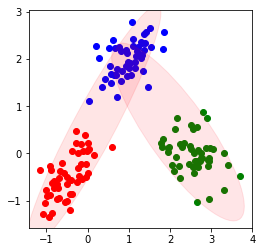

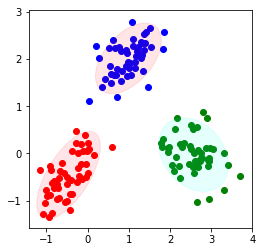

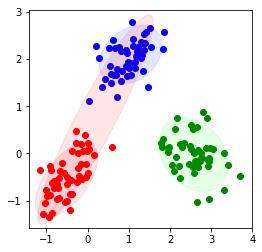

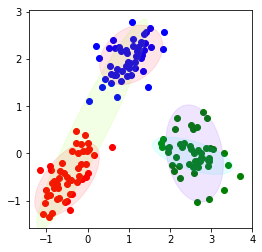

================= data 2 ==================


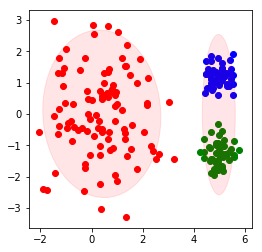

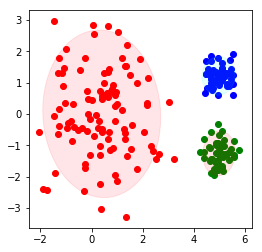

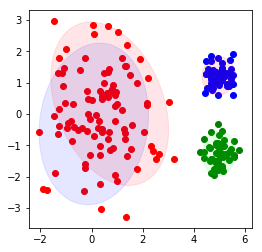

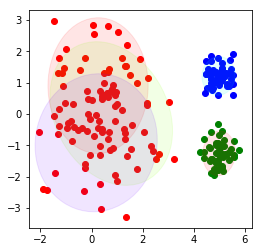

================= data 3 ==================


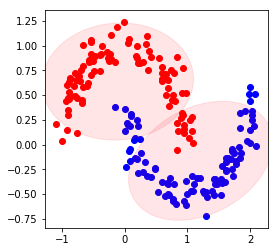

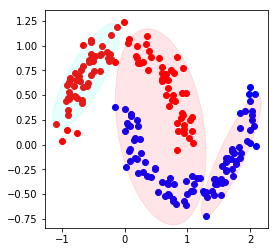

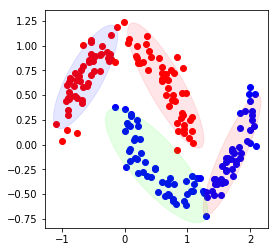

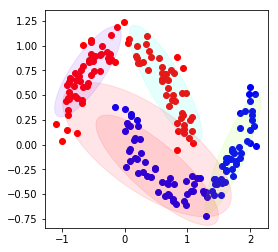

In [9]:
print("================= data 1 ==================")
data1_GMM_results = []
for K in range(2, 6):
    mus_best, covs_best, log_gammas_best, LLs_best = GMM(data1, K, num_restarts = 1)
    cluster_assignments = np.argmax(log_gammas_best, axis=1)
    plot_clusters(data1, mus_best, covs_best, labels1, K)
    data1_GMM_results.append((mus_best, covs_best, cluster_assignments, LLs_best[-1]))
print("================= data 2 ==================")
data2_GMM_results = []
for K in range(2, 6):
    mus_best, covs_best, log_gammas_best, LLs_best = GMM(data2, K, num_restarts = 10)
    cluster_assignments = np.argmax(log_gammas_best, axis=1)
    plot_clusters(data2, mus_best, covs_best, labels2, K)
    data2_GMM_results.append((mus_best, covs_best, cluster_assignments, LLs_best[-1]))
print("================= data 3 ==================")
data3_GMM_results = []
for K in range(2, 6):
    mus_best, covs_best, log_gammas_best, LLs_best = GMM(data3, K, num_restarts = 10)
    cluster_assignments = np.argmax(log_gammas_best, axis=1)
    plot_clusters(data3, mus_best, covs_best, labels3, K)
    data3_GMM_results.append((mus_best, covs_best, cluster_assignments, LLs_best[-1]))

## Evaluation of GMM

In [10]:
def get_clustering_scores_GMM(data_matrix, true_labels, GMM_results): 
    """
    """
    means, variances, predicted_labels, log_likelihood = GMM_results
    NMI = normalized_mutual_info_score(true_labels, predicted_labels)
    SC = 0 
    CH = 0
    try: 
        SC = silhouette_score(data_matrix, predicted_labels)
        CH = calinski_harabaz_score(data_matrix, predicted_labels)
    except ValueError: 
        print("number of clusters = 1")
        
    print("\t NMI: ", NMI)
    print("\t SC: ", SC) 
    print("\t CH: ", CH)
    print("\t Log Likelihood: ", log_likelihood)
    print("------------------------------------------")
    
    return (NMI, SC, CH, log_likelihood)

In [11]:
scores_clustering_data1_GMM = [get_clustering_scores_GMM(data1, data1_labels, data1_GMM_results[i]) 
                           for i in range(4)]

print("========================= scores for data 2 =========================")

scores_clustering_data2_GMM = [get_clustering_scores_GMM(data2, data2_labels, data2_GMM_results[i]) 
                           for i in range(4)]

print("========================= scores for data 3 =========================")

scores_clustering_data3_GMM = [get_clustering_scores_GMM(data3, data3_labels, data3_GMM_results[i]) 
                           for i in range(4)]

	 NMI:  0.6194283382845717
	 SC:  0.41251489625230736
	 CH:  84.84027138473502
	 Log Likelihood:  -266.4556627128086
------------------------------------------
	 NMI:  1.0
	 SC:  0.7222054254371456
	 CH:  599.5385825621063
	 Log Likelihood:  -131.1295494517176
------------------------------------------
	 NMI:  0.8594239258786972
	 SC:  0.5750134436772817
	 CH:  434.8981568143347
	 Log Likelihood:  -78.54404834164795
------------------------------------------
	 NMI:  0.7869455097812295
	 SC:  0.3798738378939436
	 CH:  327.4311985141249
	 Log Likelihood:  -15.806318679412314
------------------------------------------
========================= scores for data 2 =========================
	 NMI:  0.8164965809277255
	 SC:  0.6026993218507501
	 CH:  427.9441356092637
	 Log Likelihood:  -522.3572877178345
------------------------------------------
	 NMI:  1.0
	 SC:  0.620963689910095
	 CH:  355.4914098063913
	 Log Likelihood:  -387.21511234260095
------------------------------------------
	 NM

GMM: data 1 NMI scores for clusters with k in the x axis and the score in the y


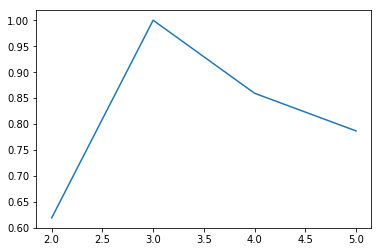

GMM: data 1 CH scores for clusters with k in the x axis and the score in the y


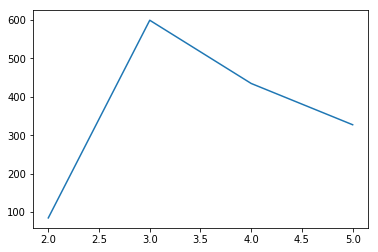

GMM: data 1 SC scores for clusters with k in the x axis and the score in the y


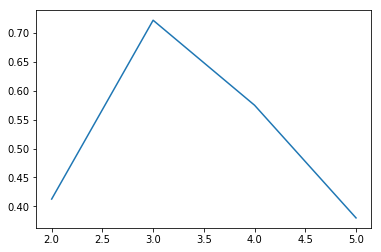

GMM: data 1 log likelihood scores for clusters with k in the x axis and the score in the y


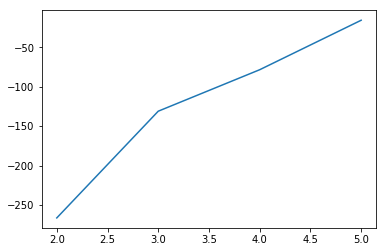

data 2 NMI scores for clusters with k in the x axis and the score in the y


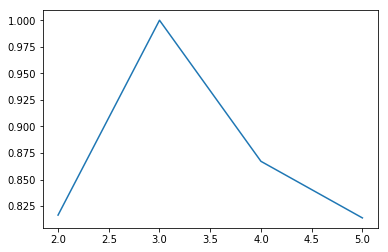

data 2 CH scores for clusters with k in the x axis and the score in the y


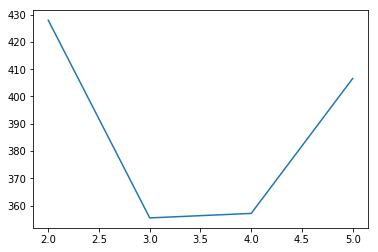

data 2 SC scores for clusters with k in the x axis and the score in the y


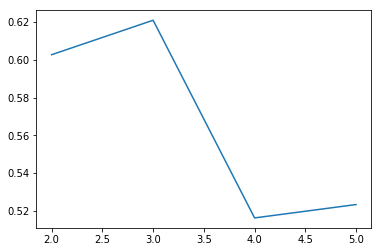

data 2 log likelihood scores for clusters with k in the x axis and the score in the y


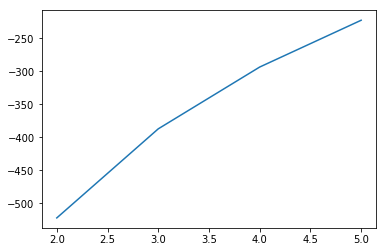

data 3 NMI scores for clusters with k in the x axis and the score in the y


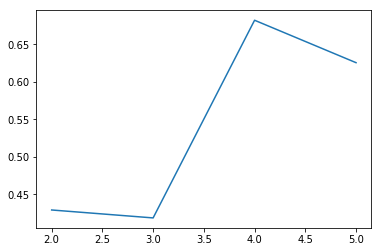

data 3 CH scores for clusters with k in the x axis and the score in the y


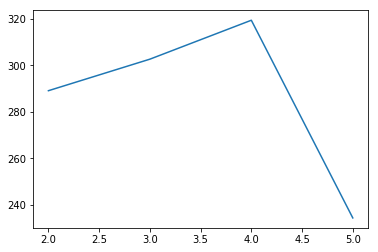

data 3 SC scores for clusters with k in the x axis and the score in the y


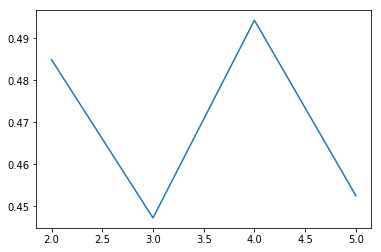

data 3 log likelihood scores for clusters with k in the x axis and the score in the y


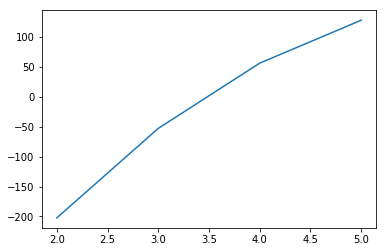

In [12]:
NMI_data1_GMM = []
SC_data1_GMM = []
CH_data1_GMM = []
ll_data1_GMM = []

for NMI, SC, CH, ll in scores_clustering_data1_GMM: 
    NMI_data1_GMM.append(NMI)
    SC_data1_GMM.append(SC)
    CH_data1_GMM.append(CH)
    ll_data1_GMM.append(ll)
###################################################    
NMI_data2_GMM = []
SC_data2_GMM = []
CH_data2_GMM = []
ll_data2_GMM = []

for NMI, SC, CH, ll in scores_clustering_data2_GMM: 
    NMI_data2_GMM.append(NMI)
    SC_data2_GMM.append(SC)
    CH_data2_GMM.append(CH)
    ll_data2_GMM.append(ll)

########################################################

NMI_data3_GMM = []
SC_data3_GMM = []
CH_data3_GMM = []
ll_data3_GMM = []

for NMI, SC, CH, ll in scores_clustering_data3_GMM: 
    NMI_data3_GMM.append(NMI)
    SC_data3_GMM.append(SC)
    CH_data3_GMM.append(CH)
    ll_data3_GMM.append(ll)

####################################################
print("GMM: data 1 NMI scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], NMI_data1_GMM)
plt.show()
    
print("GMM: data 1 CH scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], CH_data1_GMM)
plt.show()

print("GMM: data 1 SC scores for clusters with k in the x axis and the score in the y")  
plt.plot([2, 3, 4, 5], SC_data1_GMM)
plt.show()

print("GMM: data 1 log likelihood scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], ll_data1_GMM)
plt.show()


#######################################

print("data 2 NMI scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], NMI_data2_GMM)
plt.show()
    
print("data 2 CH scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], CH_data2_GMM)
plt.show()


print("data 2 SC scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], SC_data2_GMM)
plt.show()


print("data 2 log likelihood scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], ll_data2_GMM)    
plt.show()


#######################################
print("data 3 NMI scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], NMI_data3_GMM) 
plt.show()
    
print("data 3 CH scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], CH_data3_GMM)
plt.show()

print("data 3 SC scores for clusters with k in the x axis and the score in the y")  
plt.plot([2, 3, 4, 5], SC_data3_GMM)
plt.show()

print("data 3 log likelihood scores for clusters with k in the x axis and the score in the y")
plt.plot([2, 3, 4, 5], ll_data3_GMM)
plt.show()

    